In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import scipy.constants as c
from scipy import stats

from photutils.aperture import CircularAperture
from photutils.detection import DAOStarFinder
from photutils.aperture import aperture_photometry
from photutils.aperture import CircularAnnulus

from astropy.utils.data import get_pkg_data_filename
from astropy.wcs import WCS
from astropy import wcs
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy import units as u

In [2]:
#We first import MKT datacubes in all channels (I,Q,U,V)
directory = r'C:\Users\woutg\OneDrive - Universiteit Leiden\Universiteit Leiden\Bachelor 3\BRP\Meerkat_Data\Abell 85\\'
directory_univ = r'/net/vdesk/data2/GoesaertW/Meerkat Data/Abell_85/'

I_hdu = fits.open(get_pkg_data_filename(directory_univ + r'Abell_85_aFix_pol_I_Farcsec_fcube_cor.fits'))[0]
I_header = I_hdu.header
I_cube = I_hdu.data[0]
Q_hdu = fits.open(get_pkg_data_filename(directory_univ + r'Abell_85_aFix_pol_Q_Farcsec_fcube_cor.fits'))[0]
Q_cube = Q_hdu.data[0]
U_hdu = fits.open(get_pkg_data_filename(directory_univ + r'Abell_85_aFix_pol_U_Farcsec_fcube_cor.fits'))[0]
U_cube = U_hdu.data[0]
V_hdu = fits.open(get_pkg_data_filename(directory_univ + r'Abell_85_aFix_pol_V_Farcsec_fcube_cor.fits'))[0]
V_cube = V_hdu.data[0]

I_freqmean = np.nanmean(I_cube, axis=0)
Q_freqmean = np.nanmean(Q_cube, axis=0)
U_freqmean = np.nanmean(U_cube, axis=0)
V_freqmean = np.nanmean(V_cube, axis=0)

I_wcs = WCS(I_hdu.header)
Q_wcs = WCS(Q_hdu.header)
U_wcs = WCS(U_hdu.header)
V_wcs = WCS(V_hdu.header)

# We then define variables containing the subband frequencies
# Carefull: central frequencies in DR1 paper are wrong
freqs_lower = np.zeros(12)
freqs_middle = np.zeros(12)
freqs_upper = np.zeros(12)

for n in range(12):
    number = str((4-len(str(n+1)))*'0'+str(n+1))
    freqs_lower[n] = I_hdu.header['FREL'+number]
    freqs_middle[n] = I_hdu.header['FREQ'+number]
    freqs_upper[n] = I_hdu.header['FREH'+number]

In [3]:
# We calculate the linpol intensity cube:
linpol_intens_cube = np.sqrt(Q_cube**2+U_cube**2)
linpol_intens_freqmean = np.nanmean(linpol_intens_cube, axis=0)

Linpol_hdu = fits.PrimaryHDU(linpol_intens_cube)

In [4]:
# We perform some preparatory work for flux measurements.
# First step is finding the sources.
# The background statistics are found using sigma clipping.
limit = 3 #sigma
backgr_mean, backgr_median, backgr_std = sigma_clipped_stats(linpol_intens_freqmean, sigma=3.0)
print((backgr_mean, backgr_median, backgr_std))

# We then define where we are going to look for, the criteria.
daofind = DAOStarFinder(fwhm=3.0, threshold=limit*backgr_std)
mask = np.ones(linpol_intens_freqmean.shape, dtype=bool)
# If needed, this mask ensures we only select certain sources:
mask[200:-200,200:-200] = False

def create_circular_mask(h, w, center=None, radius=None):
    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
    mask_loc = dist_from_center >= radius
    return mask_loc

mask = create_circular_mask(linpol_intens_freqmean.shape[1], linpol_intens_freqmean.shape[0], radius=0.60*linpol_intens_freqmean.shape[1])

# We then do the actual sourcefinding
sources = daofind(linpol_intens_freqmean - backgr_median, mask=mask)# Median instead of mean to be less depend on outliers
# And we prepare the apertures:
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=7.)
annulus_aperture = CircularAnnulus(positions, r_in=30, r_out=40)

for col in sources.colnames:
    sources[col].info.format = '%.8g'  # for consistent table output

# This also gives some flux results, but this doesn't take beamsize/pix into account
print(sources)

(2.1956941054668278e-05, 2.0539200704661198e-05, 7.318400548683712e-06)
 id xcentroid ycentroid sharpness  ... sky      peak        flux        mag     
--- --------- --------- ---------- ... --- ------------- --------- -------------
  1 673.47897 1.5783997 0.29358518 ...   0 4.0927422e-05  1.014918  -0.016077345
  2 1097.4923 1.1805197 0.29320682 ...   0 4.2503241e-05 1.2008189   -0.19869379
  3 1989.7888 1.7429931 0.29334026 ...   0 6.7676781e-05 1.5785616   -0.49565383
  4 2380.5656 1.5304314 0.32110316 ...   0 5.5730256e-05 1.3764724   -0.34691878
  5 2391.9782 1.3553803 0.26526468 ...   0 7.3575611e-05 1.6901931   -0.56984081
  6 2429.8472 1.5008041 0.28009826 ...   0  5.876326e-05 1.2649829   -0.25521168
  7 2465.9051 1.4271385 0.27992809 ...   0 4.6242421e-05 1.0435637  -0.046297421
  8 2480.5988 1.2448366 0.29677983 ...   0 6.6067332e-05  1.767351     -0.618307
  9 2491.6107 1.4987712 0.26550186 ...   0 5.4829499e-05 1.2759369   -0.26457296
 10 2648.8746 1.0543314 0.30588727 ..

In [5]:
# We perform flux measurements:
FWHM_major_axis = 2.140979E-03*c.degree # Information from the header
FWHM_minor_axis = 1.972437E-03*c.degree
pixsize = 3.317774E-04*c.degree
delta_cal = 0.05
N = 1

def photometry(data_local, apers_local, annulus_local, psize, min_ax, maj_ax, n, delta_cal=0.05, N=1):
    # This function calculates the flux from a source
    data_local_intensity = data_local*4*np.log(2)/(np.pi*maj_ax*min_ax) # Converts Jy/beam to Jy/sr
    phot_table = aperture_photometry(data_local_intensity, apers_local)
    flux = phot_table['aperture_sum']*(psize**2)
    annulus_masks = annulus_local.to_mask()
    backgr_error = np.zeros(n)
    for i in range(n):
        annulus_data = annulus_masks[i].multiply(data_local)
        annulus_data_1d = annulus_data[annulus_masks[i].data != 0.]
        backgr_error[i] = np.std(annulus_data_1d) # error per beam due to background
    flux_error = np.sqrt((backgr_error*np.sqrt(N))**2 + (delta_cal*flux)**2)
    phot_table['flux'] = flux
    phot_table['flux_err'] = flux_error
    return phot_table

phot_table = photometry(I_freqmean, apertures, annulus_aperture, pixsize, FWHM_minor_axis, FWHM_major_axis, len(sources))
print(phot_table)

 id      xcenter       ...           flux                 flux_err       
           pix         ...                                               
--- ------------------ ... ----------------------- ----------------------
  1  673.4789651917241 ... -1.2317199879750203e-05 1.2283065194152615e-05
  2  1097.492266431081 ...  2.1178585898203485e-05  1.850400445989784e-05
  3  1989.788807168843 ...   0.0015948659159202177   8.00022040300455e-05
  4 2380.5655788990553 ... -4.1479226335248646e-05 1.0148362847925585e-05
  5 2391.9781753058196 ...  1.2891857991071986e-05 1.0873524373752191e-05
  6 2429.8471509154347 ... -1.0231409634981225e-05 1.3428655699956063e-05
  7  2465.905100026754 ...  -3.926175277337636e-05 1.4164199206918517e-05
  8 2480.5987595026277 ...  2.9681794876982788e-06 1.3009570185269766e-05
  9   2491.61069399458 ... -1.5526089126620364e-05 1.1353941897036482e-05
 10 2648.8746196880115 ...    3.11268254468203e-05 1.2744432526257418e-05
...                ... ...            

In [6]:
# Flux measurements are performed in all channels and saved in tables
I_phot_table, I_phot_table_err = np.zeros((12, len(sources))), np.zeros((12, len(sources)))
Q_phot_table, Q_phot_table_err = np.zeros((12, len(sources))), np.zeros((12, len(sources)))
U_phot_table, U_phot_table_err = np.zeros((12, len(sources))), np.zeros((12, len(sources)))
V_phot_table, V_phot_table_err = np.zeros((12, len(sources))), np.zeros((12, len(sources)))

for n in range(12):
    I_slice_phot = photometry(I_cube[n], apertures, annulus_aperture, pixsize, FWHM_minor_axis, FWHM_major_axis, len(sources))
    Q_slice_phot = photometry(Q_cube[n], apertures, annulus_aperture, pixsize, FWHM_minor_axis, FWHM_major_axis, len(sources))
    U_slice_phot = photometry(U_cube[n], apertures, annulus_aperture, pixsize, FWHM_minor_axis, FWHM_major_axis, len(sources))
    V_slice_phot = photometry(V_cube[n], apertures, annulus_aperture, pixsize, FWHM_minor_axis, FWHM_major_axis, len(sources))

    for i in range(len(sources)):
        I_phot_table[n, i], I_phot_table_err[n, i] = I_slice_phot[i]['flux'], I_slice_phot[i]['flux_err']
        Q_phot_table[n, i], Q_phot_table_err[n, i] = Q_slice_phot[i]['flux'], Q_slice_phot[i]['flux_err']
        U_phot_table[n, i], U_phot_table_err[n, i] = U_slice_phot[i]['flux'], U_slice_phot[i]['flux_err']
        V_phot_table[n, i], V_phot_table_err[n, i] = V_slice_phot[i]['flux'], V_slice_phot[i]['flux_err']

In [7]:
I_wcs_new = wcs.WCS(I_header).celestial
width, height = linpol_intens_freqmean.shape[0], linpol_intens_freqmean.shape[1]
point_center = I_wcs_new.pixel_to_world(width/2, height/2)
loc_world = I_wcs_new.pixel_to_world(sources['xcentroid'], sources['ycentroid']).data
sources['ra_dec']=loc_world
distances_pointing = np.sqrt((loc_world.lon.degree-point_center.data.lon.degree)**2+(loc_world.lat.degree-point_center.data.lat.degree)**2) #This is an approximation
sources['distance_center']= distances_pointing

In [9]:
savedir = r'C:\Users\woutg\OneDrive - Universiteit Leiden\Universiteit Leiden\Bachelor 3\BRP\Meerkat_Data\Abell 85\Photometry\\'
savedir_univ = r'/net/vdesk/data2/GoesaertW/Meerkat Data/Abell_85/Photometry/'

np.save(savedir_univ+'Abell85_I.npy', I_phot_table)
np.save(savedir_univ+'Abell85_Q.npy', Q_phot_table)
np.save(savedir_univ+'Abell85_U.npy', U_phot_table)
np.save(savedir_univ+'Abell85_V.npy', V_phot_table)

np.save(savedir_univ+'Abell85_I_err.npy', I_phot_table_err)
np.save(savedir_univ+'Abell85_Q_err.npy', Q_phot_table_err)
np.save(savedir_univ+'Abell85_U_err.npy', U_phot_table_err)
np.save(savedir_univ+'Abell85_V_err.npy', V_phot_table_err)

np.save(savedir_univ+'Abell85_sources.npy',sources)
print(sources[0])

 id xcentroid ycentroid sharpness   roundness1  roundness2 npix sky      peak       flux       mag                ra_dec            distance_center  
                                                                                                                   deg                               
--- --------- --------- ---------- ----------- ----------- ---- --- ------------- -------- ------------ -------------------------- ------------------
  1 673.47897 1.5783997 0.29358518 -0.59440743 -0.52899235   25   0 4.0927422e-05 1.014918 -0.016077345 (10.83494724, -9.91706311) 0.7108512199574956


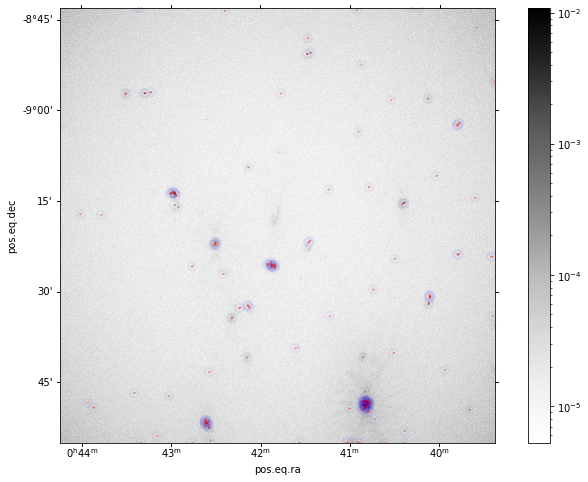

In [17]:
# We plot the selected sources with their apertures on the Meerkat data
plt.figure(figsize=(12,8))
plt.title('Apertures of selected sources plotted on linpol intensity')
plt.subplot(projection=I_wcs, slices=('x', 'y', 0, 0))
plt.imshow(linpol_intens_freqmean.clip(min=0.0000001), cmap='Greys', origin='lower', norm=colors.LogNorm(), interpolation='nearest')
plt.colorbar()
apertures.plot(color='red', lw=0.2)
annulus_aperture.plot(color='blue', alpha=0.2, lw=0.2, label='Background annulus')
for n in range(len(sources)):
    plt.text(sources['xcentroid'][n]+5, sources['ycentroid'][n]+5, sources['id'][n], size=1, color='red')
plt.savefig('ACO85_Linpol_Freqmean_Apers.pdf', dpi=100)